In [1]:
from citrination_client import CitrinationClient
import saxskit
from saxskit.saxskit.saxs_models import get_data_from_Citrination

from pypif.pif import dumps
import json 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import yaml
from sklearn import preprocessing
from sklearn import linear_model
import sklearn
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import LeavePGroupsOut

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.neighbors.kde import KernelDensity
from time import time

In [2]:
with open("citrination_api_key_ssrl.txt", "r") as g: 
    api_key = g.readline()

a_key = api_key.strip()

client = CitrinationClient(site='https://slac.citrination.com',api_key=a_key ) 

In [3]:
t0 = time()
d = get_data_from_Citrination(client, [1,15,16])
print("It took ", time()-t0)

It took  124.49225401878357


In [4]:
d.head()

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,guinier_porod,spherical_normal,diffraction_peaks,G_gp,rg_gp,D_gp,I0_sphere,r0_sphere,sigma_sphere,I0_floor
948,R6,69.6784,2.71303,0.00232372,42.5446,4.11995,0.0812712,0.00185529,0.0933219,-0.546811,...,0,1,1,None,None,None,None,None,None,0
562,R4,1.44855,1.19832,0.0225415,5.65807,2.75074,0.143148,0.00185529,0.299214,0.293792,...,1,0,0,2.51472,2.31895,None,None,None,None,0.0337671
1175,R12,16.2602,1.02895,0.00104027,3.45984,2.83132,0.103267,0.00171821,0.0688484,-0.764441,...,0,1,0,None,None,None,790.178,31.3774,0.0454279,0.206495
269,R1,18.5594,1.03069,0.00109416,3.20008,2.78637,0.107467,0.00185529,0.0651967,-0.639523,...,0,1,0,None,None,None,1763.36,33.6887,0.0564587,0.0868149
1476,Reaction_A,3.77951,1.11135,0.0066177,19.7709,4.27128,0.125508,0.00238663,0.216581,0.256296,...,1,0,0,22.2753,4.86282,None,None,None,None,0


In [5]:
d.shape

(1946, 25)

**Steps to get a good linear regression model**
(by https://machinelearningmastery.com/linear-regression-for-machine-learning/)
1. Linear Assumption. Linear regression assumes that the relationship between your input and output is linear. You may need to transform data to make the relationship linear (e.g. log transform for an exponential relationship).
2. Remove Noise. Linear regression assumes that your input and output variables are not noisy. Consider using data cleaning operations that let you better expose and clarify the signal in your data. This is most important for the output variable and you want to remove outliers in the output variable (y) if possible.
3. Remove Collinearity. Linear regression will over-fit your data when you have highly correlated input variables. Consider calculating pairwise correlations for your input data and removing the most correlated.
4. Gaussian Distributions. Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution. You may get some benefit using transforms (e.g. log or BoxCox) on you variables to make their distribution more Gaussian looking.
5. Rescale Inputs: Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

In [8]:
data = d

### My Strategy for Dealing with Outliers

1. Exclude outliers for labels
2. At training / testing time exclude outliers from training and validation sets, but not exclude them from testing set.

## Spherical scatterer - size distribution paramentrs
### ro_sphere (mean radius)

In [14]:
data_sphere = d[d['r0_sphere'].isnull() == False]
data_sphere.shape

(726, 25)

In [15]:
data_sphere.experiment_id.value_counts()

R1            240
R12           117
R5             79
R13            77
Reaction_C     54
Reaction_D     42
Reaction_H     38
Reaction_E     36
Reaction_G      7
Reaction_A      6
R4              6
R2              5
R6              5
R7              5
Reaction_B      5
R3              4
Name: experiment_id, dtype: int64

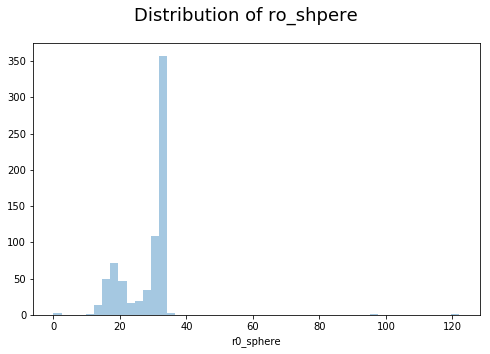

In [18]:
plt.figure(figsize=(8,5))
sns.distplot(data_sphere['r0_sphere'], kde=False, bins=50)
plt.suptitle("Distribution of ro_shpere ", fontsize=18)

In [19]:
d.columns

Index(['experiment_id', 'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq', 'unidentified', 'guinier_porod',
       'spherical_normal', 'diffraction_peaks', 'G_gp', 'rg_gp', 'D_gp',
       'I0_sphere', 'r0_sphere', 'sigma_sphere', 'I0_floor'],
      dtype='object')

In [20]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

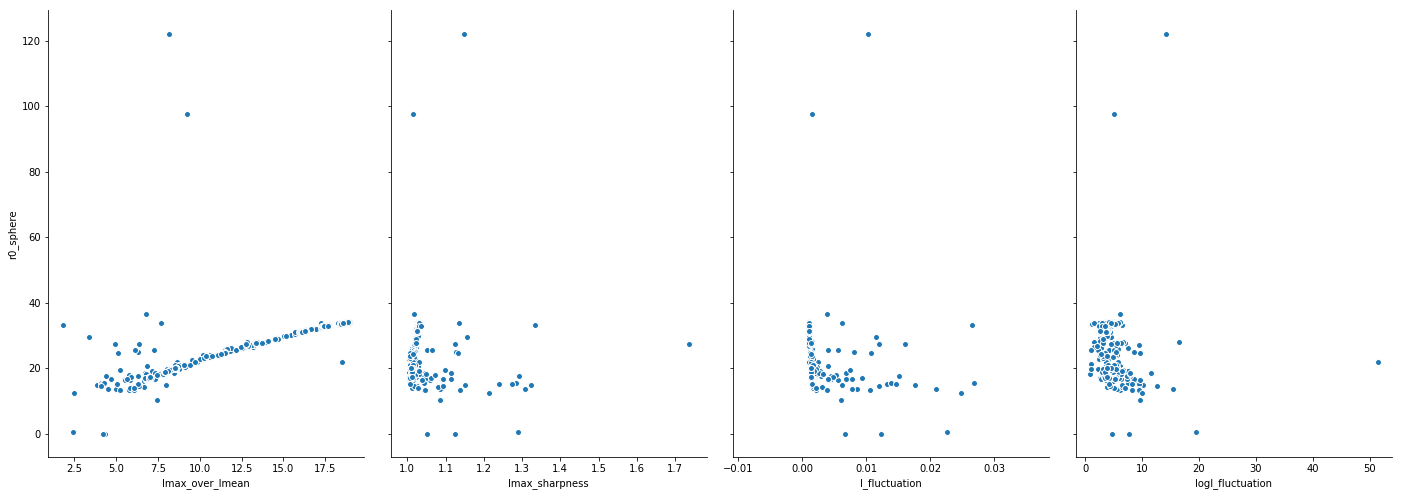

In [22]:
sns.pairplot(data_sphere, x_vars=['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation'], y_vars='r0_sphere', size=7, aspect=0.7)

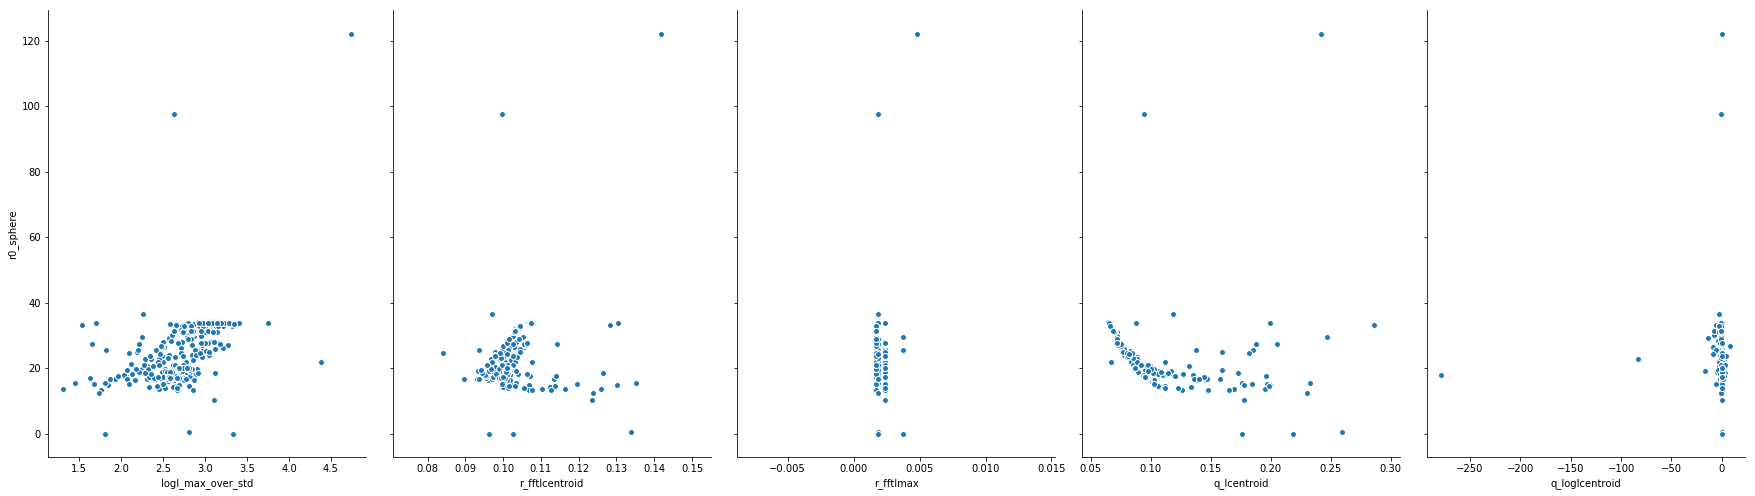

In [23]:
sns.pairplot(data_sphere, x_vars=['logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid'], y_vars='r0_sphere', size=7, aspect=0.7)

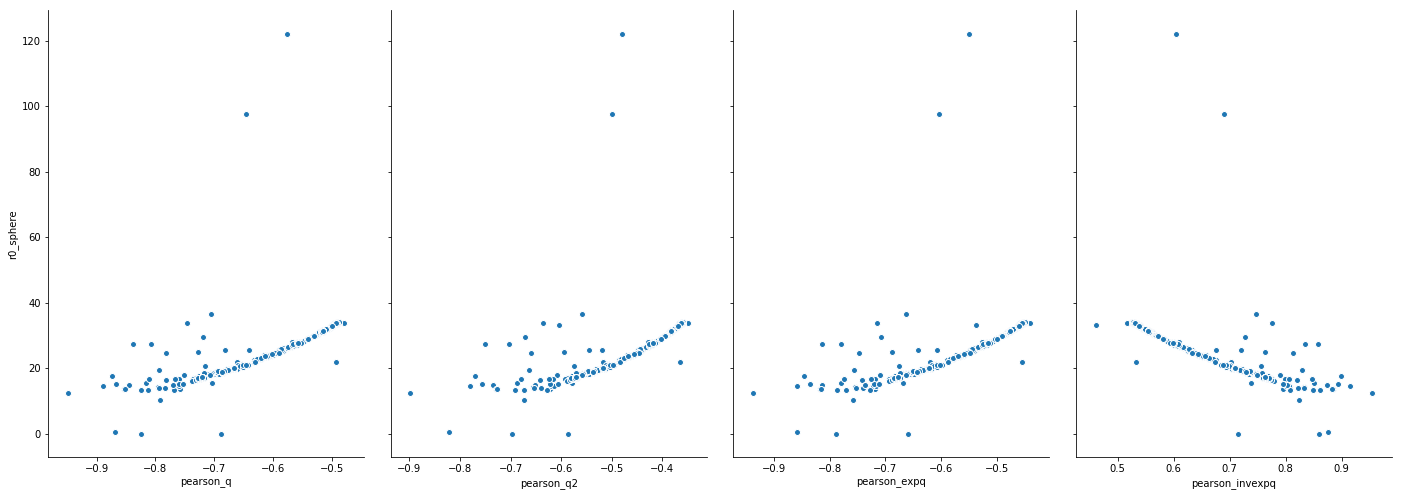

In [24]:
sns.pairplot(data_sphere, x_vars=['pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq'], y_vars='r0_sphere', size=7, aspect=0.7)

This visualization shows that:
1. We have only two features that are correlated with 'ro_shpere'
2. We have some outliers.

In [25]:
scaler = preprocessing.StandardScaler()
scaler.fit(data_sphere[features])
data_sphere[features] = scaler.transform(data_sphere[features])
data_sphere.head()

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,guinier_porod,spherical_normal,diffraction_peaks,G_gp,rg_gp,D_gp,I0_sphere,r0_sphere,sigma_sphere,I0_floor
1175,R12,0.355818,-0.065367,-0.269532,-0.396362,-0.033540,-0.316003,-0.824645,-0.384650,0.012592,...,0,1,0,None,None,None,790.178,31.3774,0.0454279,0.206495
269,R1,0.826148,-0.024566,-0.249119,-0.505172,-0.179696,0.576426,-0.370667,-0.510710,0.024113,...,0,1,0,None,None,None,1763.36,33.6887,0.0564587,0.0868149
806,R5,0.864376,0.002619,-0.249314,0.034310,1.038479,0.614819,-0.370667,-0.502989,0.076497,...,0,1,0,None,None,None,2003.9,33.9429,0.0412616,0.299991
1796,Reaction_E,-1.451983,1.248246,1.647264,2.209422,0.843064,3.977933,1.389109,3.369816,0.092515,...,1,1,0,4.3769,4.66359,None,13.9542,10.3025,0.644579,0.00477838
164,R1,0.879416,0.042510,-0.247915,0.241515,0.628175,0.660092,-0.370667,-0.515636,0.058913,...,0,1,0,None,None,None,1391.76,33.889,0.0339873,0.256534


In [26]:
#remove outliers for target variables only
labels = ['r0_sphere']
st =  data_sphere[labels].std()
m = data_sphere[labels].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_sphere[labels].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

data_sphere = pd.concat([data_sphere.loc[:,c], filt_df], axis=1)
data_sphere.dropna(inplace=True)
data_sphere.shape

(721, 15)

In [27]:
data_sphere_test = data_sphere

In [28]:
# training data: remove outliers from features
st =  data_sphere[features].std()
m = data_sphere[features].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_sphere[features].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'r0_sphere']
data_sphere = pd.concat([data_sphere.loc[:,c], filt_df], axis=1)
data_sphere.dropna(inplace=True)
data_sphere.shape

(683, 15)

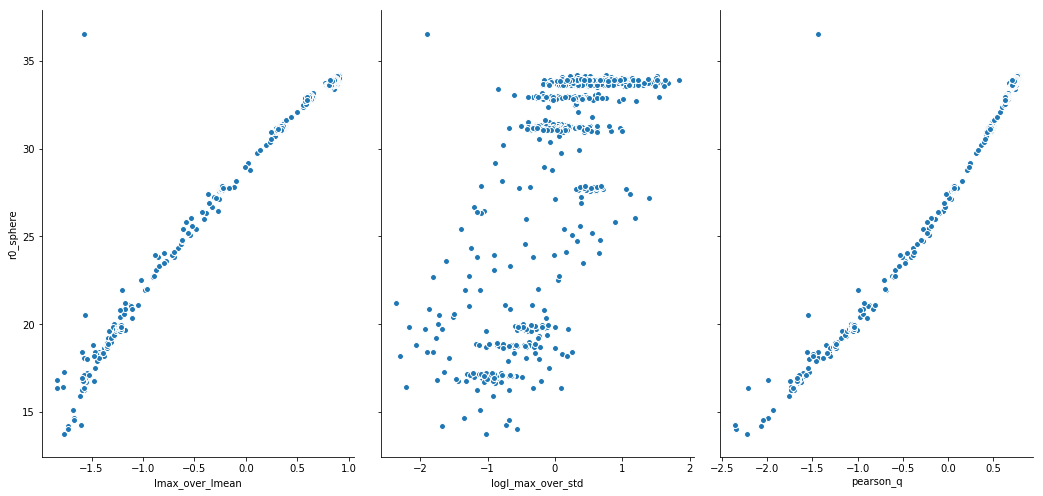

In [31]:
sns.pairplot(data_sphere, x_vars=[ 'Imax_over_Imean',  
                                 'logI_max_over_std', "pearson_q"], y_vars='r0_sphere', size=7, aspect=0.7)

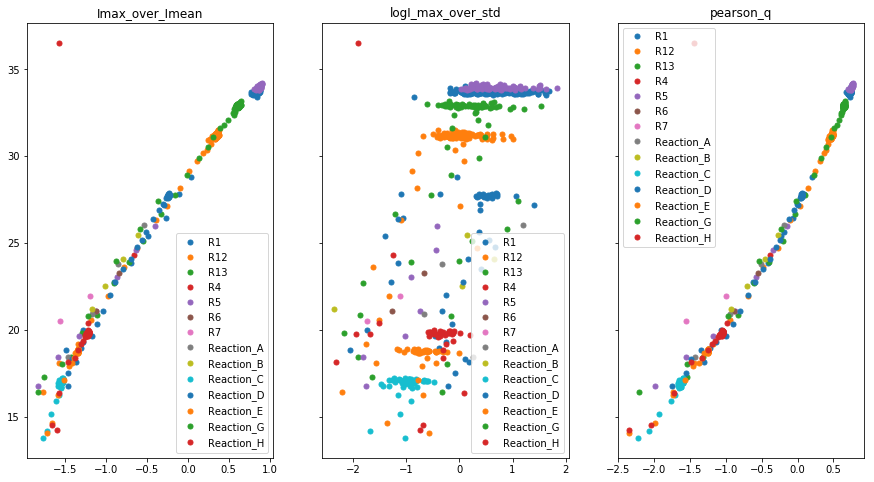

In [32]:
groups = data_sphere.groupby('experiment_id')

fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
ax3.margins(0.05)
for name, group in groups:
    ax1.plot(group.Imax_over_Imean, group.r0_sphere, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Imax_over_Imean')
ax1.legend()

for name, group in groups:
    ax2.plot(group.logI_max_over_std, group.r0_sphere, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('logI_max_over_std')
ax2.legend()

for name, group in groups:
    ax3.plot(group.pearson_q, group.r0_sphere, marker='o', linestyle='', ms=5, label=name)
ax3.set_title('pearson_q')
ax3.legend()

plt.show()

#### Loss 

* ‘squared_loss’ ordinary least squares fit
* ‘huber’modifies ‘squared_loss’ to focus less on getting outliers correct by switching from squared to linear loss past a distance of epsilon.  
* ‘epsilon_insensitive’ignores errors less than epsilon and is linear past that; 
* ‘squared_epsilon_insensitive’is the same but becomes squared loss past a tolerance of epsilon.

**We have grouped data. From some experiments we have a lot of almost the same samples, but from some other experiments we have few uniqe data. Thus, I decided to use weighted loss function. Samples that are from the same experimets and that are close in the features space will have less weight that "single" samples.**

In [33]:
data_sphere.experiment_id.value_counts()

R1            234
R12           115
R5             76
R13            74
Reaction_C     51
Reaction_D     40
Reaction_H     37
Reaction_E     35
Reaction_G      6
Reaction_A      4
Reaction_B      4
R4              3
R6              2
R7              2
Name: experiment_id, dtype: int64

Remouving outliers we lost data from R3

In [34]:
experiments = data_sphere.experiment_id.unique()
experiments

array(['R1', 'R4', 'R5', 'R6', 'R7', 'R12', 'R13', 'Reaction_A',
       'Reaction_B', 'Reaction_C', 'Reaction_D', 'Reaction_E',
       'Reaction_G', 'Reaction_H'], dtype=object)

In [43]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']


parameters = {'loss':('huber', 'squared_loss'), # huber with epsilon = 0 gives us abs error (MAE)
              'epsilon': [1, 0.1, 0.01, 0.001, 0],
              'penalty':['none', 'l2', 'l1', 'elasticnet'], #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['r0_sphere']], groups=data_sphere['experiment_id'])

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['r0_sphere'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.001, 'l1_ratio': 0, 'loss': 'squared_loss', 'penalty': 'l1'}
Training score R2:  0.953


In [44]:
std_ro_shpere = data_sphere_test['r0_sphere'].std()

In [45]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'squared_loss', penalty = 'l1', max_iter=1000)
        reg.fit(tr[features], tr['r0_sphere'])
        test_r2 = reg.score(test[features], test['r0_sphere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['r0_sphere'])
        print('test score mean squared error normalized: ', test_score / std_ro_shpere)
        test_scores_by_ex.append(test_score/std_ro_shpere)
        stat_dic[experiments[i]] = test_score/std_ro_shpere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  0.883923555467
test score mean squared error normalized:  0.0286215742664

Testing on:  R4
R2 score:  -0.250993690179
test score mean squared error normalized:  0.635418747957

Testing on:  R5
R2 score:  0.99642442934
test score mean squared error normalized:  0.0213013294867

Testing on:  R6
R2 score:  0.921023285865
test score mean squared error normalized:  0.0801157211057

Testing on:  R7
R2 score:  0.391158967818
test score mean squared error normalized:  0.328227658752

Testing on:  R12
R2 score:  0.851471146214
test score mean squared error normalized:  0.0549767806476

Testing on:  R13
R2 score:  0.85179387672
test score mean squared error normalized:  0.0869895350047

Testing on:  Reaction_A
R2 score:  0.991149960533
test score mean squared error normalized:  0.0598173314748

Testing on:  Reaction_B
R2 score:  0.970983655561
test score mean squared error normalized:  0.0876940040023

Testing on:  Reaction_C
R2 score:  0.758820130395
test score mean s

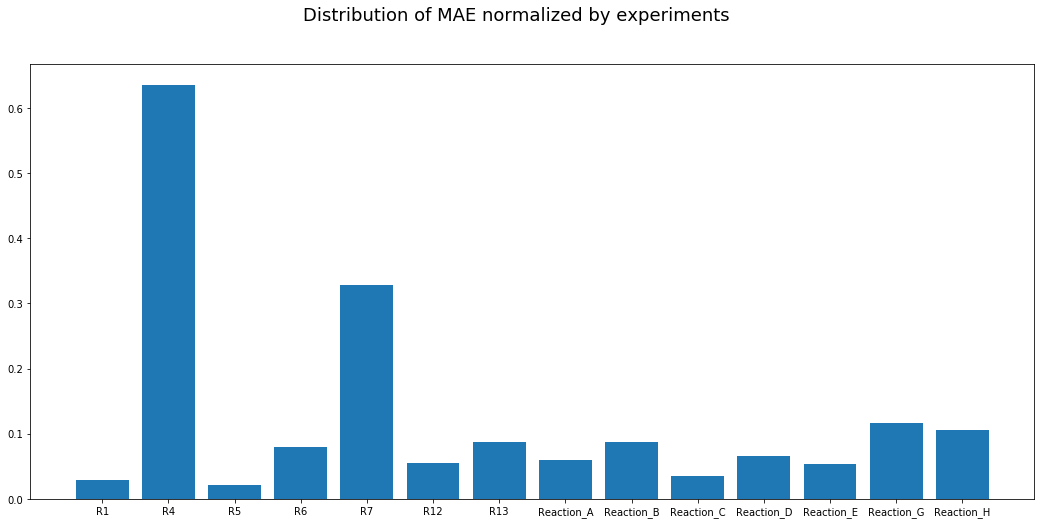

In [46]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

### Sigma-sphere

In [48]:
data_ss = d[d['sigma_sphere'].isnull() == False]
data_ss.shape

(726, 25)

In [54]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']


scaler = preprocessing.StandardScaler()
scaler.fit(data_ss[features])
data_ss[features] = scaler.transform(data_ss[features])
data_ss.head()

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,guinier_porod,spherical_normal,diffraction_peaks,G_gp,rg_gp,D_gp,I0_sphere,r0_sphere,sigma_sphere,I0_floor
1175,R12,0.355818,-0.065367,-0.269532,-0.396362,-0.033540,-0.316003,-0.824645,-0.384650,0.012592,...,0,1,0,None,None,None,790.178,31.3774,0.0454279,0.206495
269,R1,0.826148,-0.024566,-0.249119,-0.505172,-0.179696,0.576426,-0.370667,-0.510710,0.024113,...,0,1,0,None,None,None,1763.36,33.6887,0.0564587,0.0868149
806,R5,0.864376,0.002619,-0.249314,0.034310,1.038479,0.614819,-0.370667,-0.502989,0.076497,...,0,1,0,None,None,None,2003.9,33.9429,0.0412616,0.299991
1796,Reaction_E,-1.451983,1.248246,1.647264,2.209422,0.843064,3.977933,1.389109,3.369816,0.092515,...,1,1,0,4.3769,4.66359,None,13.9542,10.3025,0.644579,0.00477838
164,R1,0.879416,0.042510,-0.247915,0.241515,0.628175,0.660092,-0.370667,-0.515636,0.058913,...,0,1,0,None,None,None,1391.76,33.889,0.0339873,0.256534


In [55]:
#remove outliers for target variables only
labels = ['sigma_sphere']
st =  data_ss[labels].std()
m = data_ss[labels].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_ss[labels].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

data_ss = pd.concat([data_ss.loc[:,c], filt_df], axis=1)
data_ss.dropna(inplace=True)
data_ss.shape

(719, 15)

In [56]:
data_ss_test = data_ss

In [57]:
# training data: remove outliers from features
st =  data_ss[features].std()
m = data_ss[features].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_ss[features].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'sigma_sphere']
data_ss = pd.concat([data_ss.loc[:,c], filt_df], axis=1)
data_ss.dropna(inplace=True)
data_ss.shape

(682, 15)

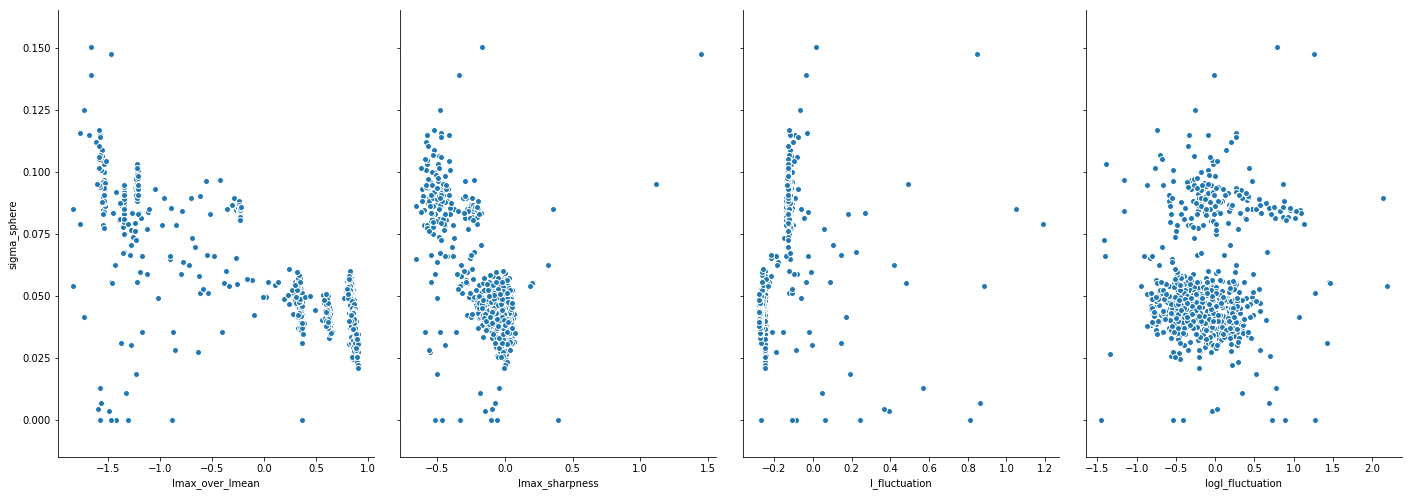

In [58]:
sns.pairplot(data_ss, x_vars=['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation'], y_vars='sigma_sphere', size=7, aspect=0.7)

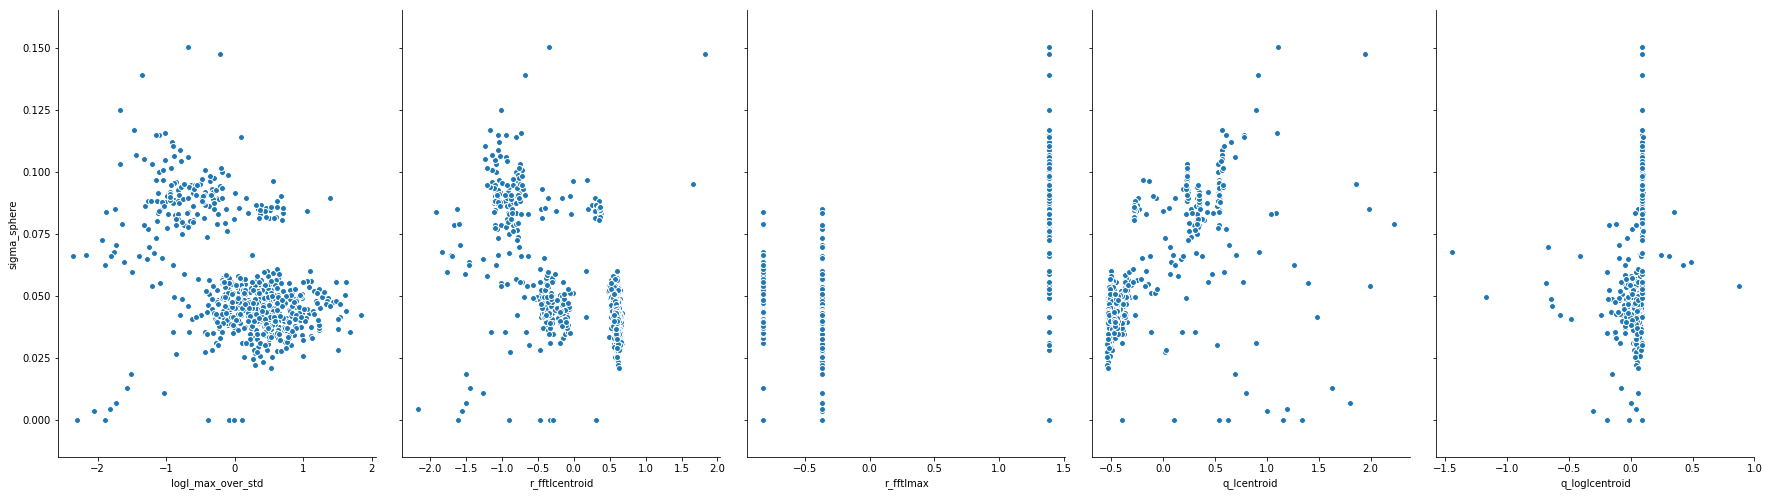

In [59]:
sns.pairplot(data_ss, x_vars=['logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid'], y_vars='sigma_sphere', size=7, aspect=0.7)

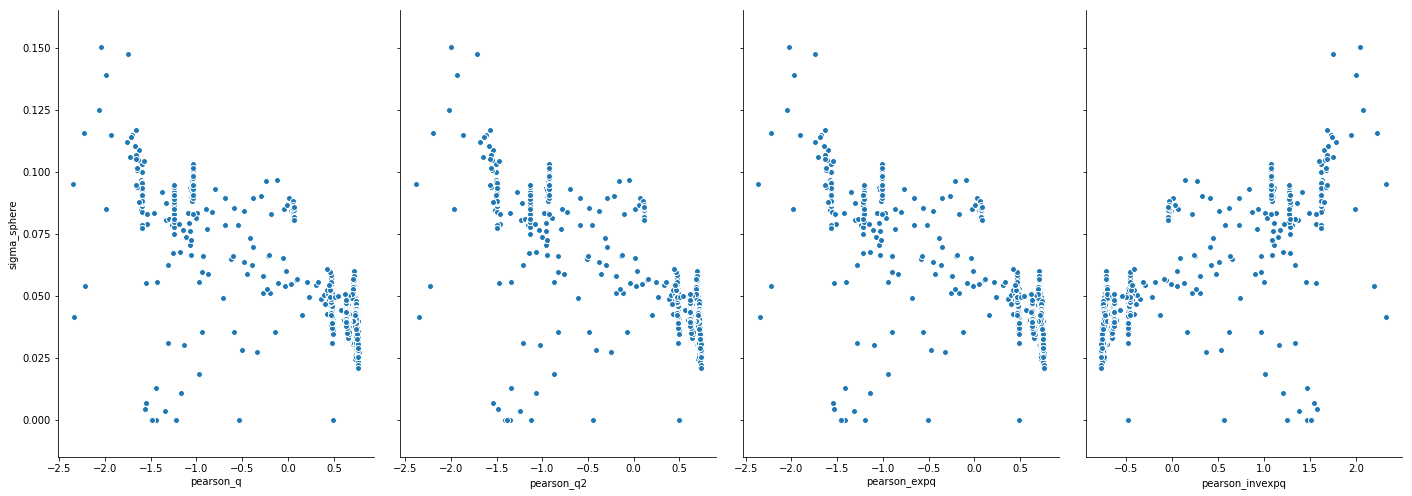

In [60]:
sns.pairplot(data_ss, x_vars=['pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq'], y_vars='sigma_sphere', size=7, aspect=0.7)

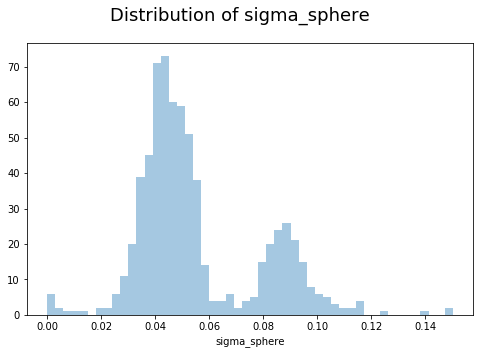

In [61]:
plt.figure(figsize=(8,5))
sns.distplot(data_ss['sigma_sphere'], kde=False, bins=50)
plt.suptitle("Distribution of sigma_sphere ", fontsize=18)

#### Using all features

In [66]:
cv=LeavePGroupsOut(n_groups=1).split(data_ss[features], data_ss[['sigma_sphere']], groups=data_ss['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_ss[features], data_ss['sigma_sphere'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.001, 'l1_ratio': 0, 'loss': 'huber', 'penalty': 'l2'}
Training score R2:  -0.754


In [67]:
std_sigma_sphere = data_ss_test['sigma_sphere'].std()

In [69]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_ss[(data_ss['experiment_id']!= experiments[i]) ]
        test = data_ss_test[(data_ss_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01,epsilon= 0.001, loss= 'huber', penalty= 'l2', max_iter=1000)
        reg.fit(tr[features], tr['sigma_sphere'])
        test_r2 = reg.score(test[features], test['sigma_sphere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['sigma_sphere'])
        print('test score mean squared error normalized: ', test_score / std_sigma_sphere)
        test_scores_by_ex.append(test_score/std_sigma_sphere)
        stat_dic[experiments[i]] = test_score/std_sigma_sphere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.0660845728798
test score mean squared error normalized:  0.332697541614

Testing on:  R4
R2 score:  -3.57154763166
test score mean squared error normalized:  1.82571735006

Testing on:  R5
R2 score:  -1.28620905658
test score mean squared error normalized:  0.452271055548

Testing on:  R6
R2 score:  -0.348260572815
test score mean squared error normalized:  1.3297615473

Testing on:  R7
R2 score:  -1.0720944471
test score mean squared error normalized:  1.67410169589

Testing on:  R12
R2 score:  0.0614016191689
test score mean squared error normalized:  0.265488051008

Testing on:  R13
R2 score:  0.265537342004
test score mean squared error normalized:  0.225121884926

Testing on:  Reaction_A
R2 score:  -16.850620373
test score mean squared error normalized:  1.60068098304

Testing on:  Reaction_B
R2 score:  -10.1309112904
test score mean squared error normalized:  1.29928336368

Testing on:  Reaction_C
R2 score:  -0.0615259812923
test score mean squared e

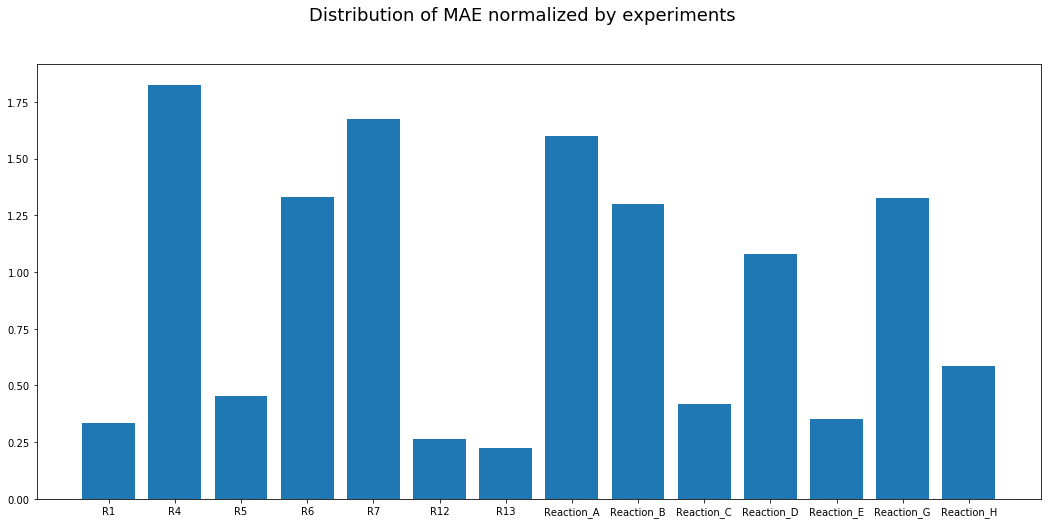

In [70]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

#### Using 'Imax_over_Imean', 'Imax_sharpness', 'q_Icentroid', 'pearson_q', 'pearson_q2', 'pearson_expq', 'pearson_invexpq'only

In [71]:
features = ['Imax_over_Imean', 'Imax_sharpness', 
       'q_Icentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

cv=LeavePGroupsOut(n_groups=1).split(data_ss[features], data_ss[['sigma_sphere']], groups=data_ss['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_ss[features], data_ss['sigma_sphere'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.001, 'l1_ratio': 0.5, 'loss': 'huber', 'penalty': 'none'}
Training score R2:  -0.459


In [72]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_ss[(data_ss['experiment_id']!= experiments[i]) ]
        test = data_ss_test[(data_ss_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01,epsilon= 0.001, loss= 'huber', penalty= 'none', max_iter=1000)
        reg.fit(tr[features], tr['sigma_sphere'])
        test_r2 = reg.score(test[features], test['sigma_sphere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['sigma_sphere'])
        print('test score mean squared error normalized: ', test_score / std_sigma_sphere)
        test_scores_by_ex.append(test_score/std_sigma_sphere)
        stat_dic[experiments[i]] = test_score/std_sigma_sphere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.189073188774
test score mean squared error normalized:  0.349984428762

Testing on:  R4
R2 score:  -2.46155735927
test score mean squared error normalized:  1.38096356856

Testing on:  R5
R2 score:  -1.45745274661
test score mean squared error normalized:  0.400637248926

Testing on:  R6
R2 score:  -0.0744710168238
test score mean squared error normalized:  1.09706011566

Testing on:  R7
R2 score:  -0.974332457982
test score mean squared error normalized:  1.65754411001

Testing on:  R12
R2 score:  -0.741916992624
test score mean squared error normalized:  0.339364060743

Testing on:  R13
R2 score:  -0.956707515077
test score mean squared error normalized:  0.304853432383

Testing on:  Reaction_A
R2 score:  -9.96572863021
test score mean squared error normalized:  1.20553327142

Testing on:  Reaction_B
R2 score:  -3.8148029269
test score mean squared error normalized:  0.887046607946

Testing on:  Reaction_C
R2 score:  0.129507355616
test score mean square

In [73]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

for f in features:
    reg = linear_model.SGDRegressor(max_iter=1000)
    reg.fit(data_ss[[f]], data_ss['sigma_sphere'])
    pred = reg.predict(data_ss[[f]])
    print("Mean squared error: %.5f"
      % mean_squared_error(data_ss['sigma_sphere'], pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.5f' % r2_score(data_ss['sigma_sphere'], pred))

Mean squared error: 0.00024
Variance score: 0.53769
Mean squared error: 0.00032
Variance score: 0.38106
Mean squared error: 0.00047
Variance score: 0.09444
Mean squared error: 0.00052
Variance score: 0.01353
Mean squared error: 0.00042
Variance score: 0.20599
Mean squared error: 0.00039
Variance score: 0.24685
Mean squared error: 0.00023
Variance score: 0.56848
Mean squared error: 0.00034
Variance score: 0.35758
Mean squared error: 0.00051
Variance score: 0.03417
Mean squared error: 0.00024
Variance score: 0.54047
Mean squared error: 0.00024
Variance score: 0.53584
Mean squared error: 0.00024
Variance score: 0.53910
Mean squared error: 0.00024
Variance score: 0.54173


In [74]:
# with variance > 0.5
features = ['Imax_over_Imean', 'r_fftImax',
        'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

cv=LeavePGroupsOut(n_groups=1).split(data_ss[features], data_ss[['sigma_sphere']], groups=data_ss['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_ss[features], data_ss['sigma_sphere'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.001, 'l1_ratio': 0, 'loss': 'huber', 'penalty': 'elasticnet'}
Training score R2:  -0.760


## Precursor paramentrs
### G_precursor

In [79]:
data_precursor = d[d['G_gp'].isnull() == False]
data_precursor.shape

(518, 25)

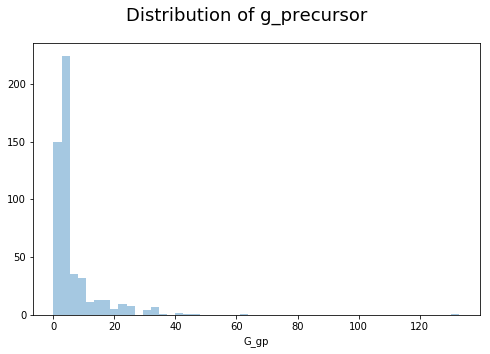

In [80]:
plt.figure(figsize=(8,5))
sns.distplot(data_precursor['G_gp'], kde=False, bins=50)
plt.suptitle("Distribution of g_precursor ", fontsize=18)

In [81]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

scaler = preprocessing.StandardScaler()
scaler.fit(data_precursor[features])
data_precursor[features] = scaler.transform(data_precursor[features])
data_precursor.head()

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,guinier_porod,spherical_normal,diffraction_peaks,G_gp,rg_gp,D_gp,I0_sphere,r0_sphere,sigma_sphere,I0_floor
562,R4,-0.957153,0.068035,1.003365,-0.936117,-0.459400,0.557858,-0.462163,0.877374,0.066830,...,1,0,0,2.51472,2.31895,None,None,None,None,0.0337671
1476,Reaction_A,-0.107433,-0.143092,-0.862717,1.163160,0.485634,-0.278132,0.088542,-0.244916,0.063910,...,1,0,0,22.2753,4.86282,None,None,None,None,0
300,R2,-0.603234,0.279463,0.718758,-0.485172,-1.184825,-0.203692,-0.462163,0.157168,0.025048,...,1,0,0,4.36756,5.17536,None,None,None,None,0.0128569
1796,Reaction_E,1.220674,-0.207368,-0.923373,-0.337782,-0.241798,-0.374478,0.088542,-0.774249,0.051902,...,1,1,0,4.3769,4.66359,None,13.9542,10.3025,0.644579,0.00477838
301,R2,-0.690887,-0.050539,0.727830,-0.113734,-0.872740,-0.492607,-0.462163,0.242174,0.050725,...,1,0,0,3.77155,4.46501,None,None,None,None,0.00860808


In [82]:
#remove outliers for target variables only
labels = ['G_gp']
st =  data_precursor[labels].std()
m = data_precursor[labels].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_precursor[labels].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

data_precursor = pd.concat([data_precursor.loc[:,c], filt_df], axis=1)
data_precursor.dropna(inplace=True)
data_precursor.shape

(500, 15)

In [84]:
data_precursor_test = data_precursor

# training data: remove outliers from features

cols = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

st =  data_precursor[cols].std()
m = data_precursor[cols].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_precursor[cols].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'G_gp']
data_precursor = pd.concat([data_precursor.loc[:,c], filt_df], axis=1)
data_precursor.dropna(inplace=True)
data_precursor.shape

(414, 15)

In [85]:
data_precursor.experiment_id.value_counts()

Reaction_B    43
R7            38
R2            37
Reaction_C    37
Reaction_D    34
Reaction_G    32
R4            31
Reaction_E    31
R6            31
Reaction_H    30
R5            24
R3            21
Reaction_A    20
R1             5
Name: experiment_id, dtype: int64

In [86]:
experiments = data_precursor.experiment_id.unique()
experiments

array(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'Reaction_A',
       'Reaction_B', 'Reaction_C', 'Reaction_D', 'Reaction_E',
       'Reaction_G', 'Reaction_H'], dtype=object)

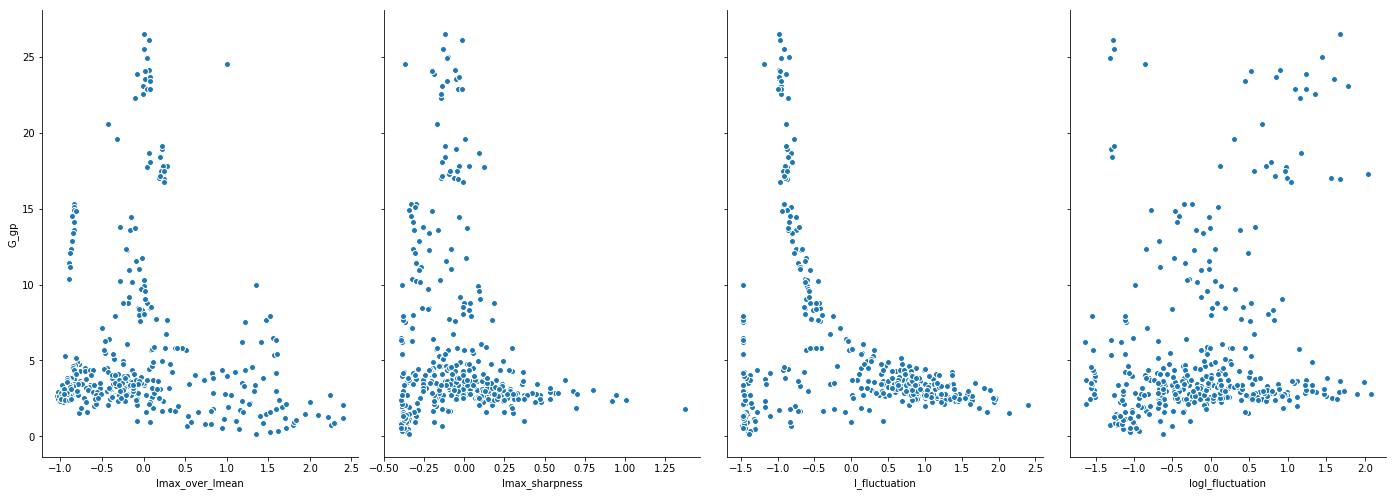

In [87]:
sns.pairplot(data_precursor, x_vars=['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation'], y_vars='G_gp', size=7, aspect=0.7)

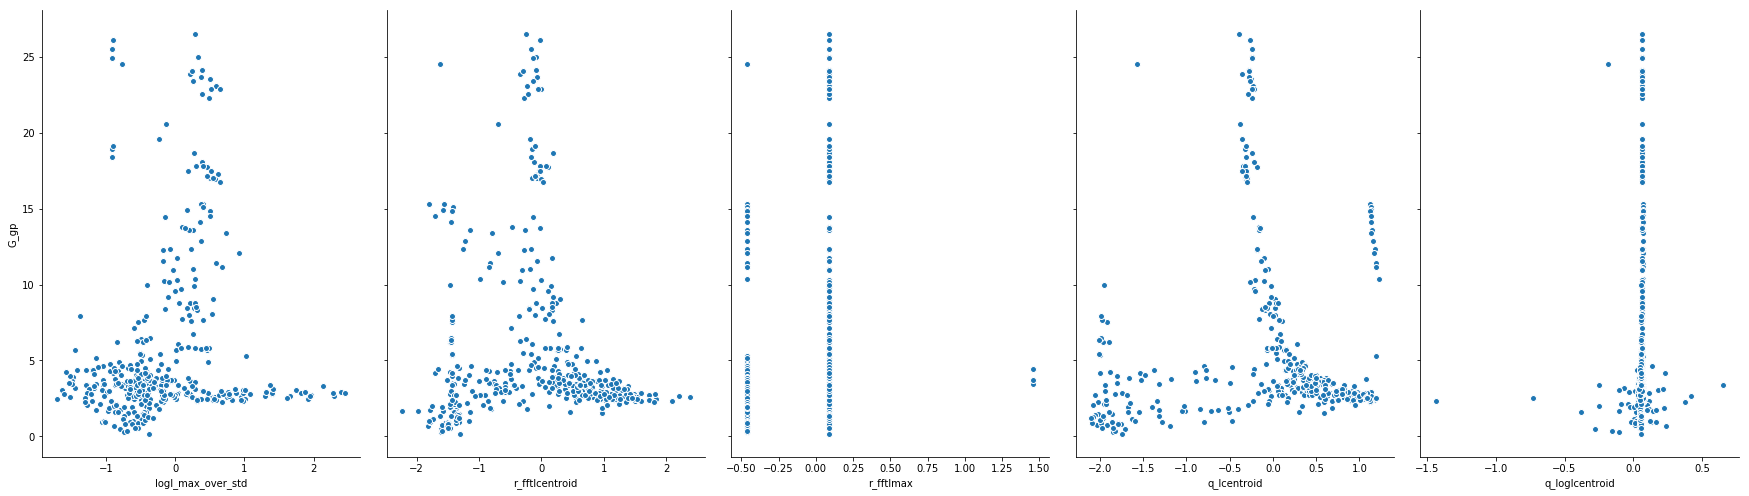

In [88]:
sns.pairplot(data_precursor, x_vars=['logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid'], y_vars='G_gp', size=7, aspect=0.7)

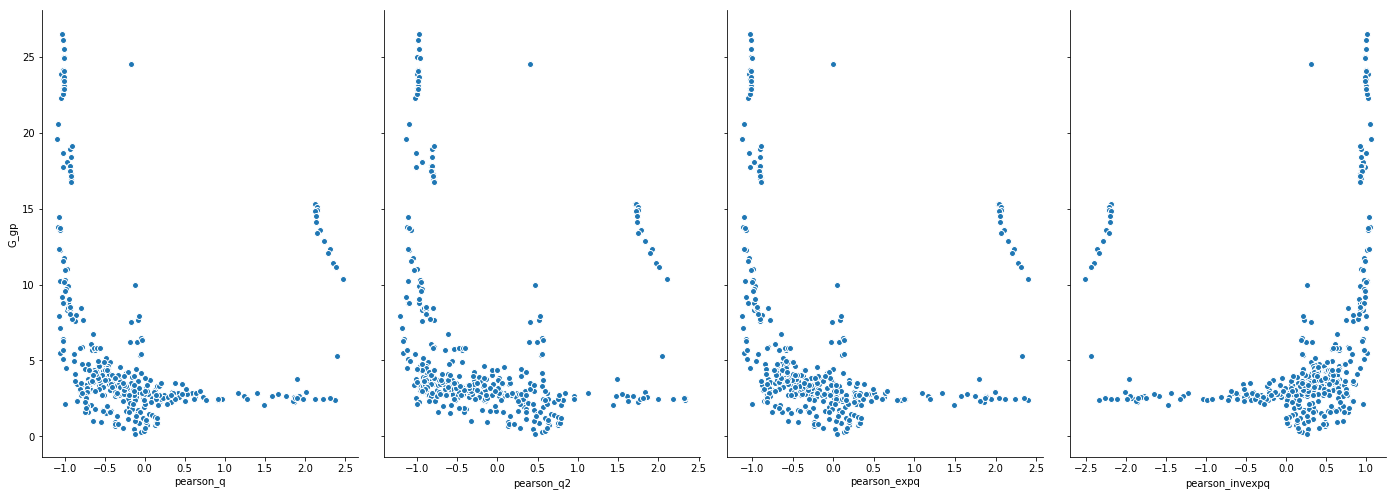

In [89]:
sns.pairplot(data_precursor, x_vars=['pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq'], y_vars='G_gp', size=7, aspect=0.7)

#### Using all features

In [91]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['G_gp']], groups=data_precursor['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['G_gp'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.1, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'elasticnet'}
Training score R2:  -0.637


In [92]:
std_g_precursor = data_precursor['G_gp'].std()

In [93]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01,epsilon= 0.001, loss= 'huber', penalty= 'none', max_iter=1000)
        reg.fit(tr[features], tr['G_gp'])
        test_r2 = reg.score(test[features], test['G_gp'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['G_gp'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.527815583008
test score mean squared error normalized:  0.188083585801

Testing on:  R2
R2 score:  -10.557887195
test score mean squared error normalized:  0.510245730343

Testing on:  R3
R2 score:  -7.95341969241
test score mean squared error normalized:  1.78211895773

Testing on:  R4
R2 score:  -0.619072278974
test score mean squared error normalized:  0.514388163343

Testing on:  R5
R2 score:  -9.95860088597
test score mean squared error normalized:  0.43882421774

Testing on:  R6
R2 score:  -10.3224521485
test score mean squared error normalized:  0.432488543007

Testing on:  R7
R2 score:  -14.9937725295
test score mean squared error normalized:  0.567465470527

Testing on:  Reaction_A
R2 score:  -1.43306927122
test score mean squared error normalized:  1.59269582933

Testing on:  Reaction_B
R2 score:  -1.18803668688
test score mean squared error normalized:  1.77577184523

Testing on:  Reaction_C
R2 score:  -1.61874881486
test score mean squared erro

#### We can try to use 1/'I_fluctuation' and 1/'pearson_q'

In [148]:
data_precursor['1/I_fluctration'] = (1 / (data_precursor['I_fluctuation'] +2)) 
data_precursor_test['1/I_fluctration'] = (1 / (data_precursor_test['I_fluctuation'] +2)) 

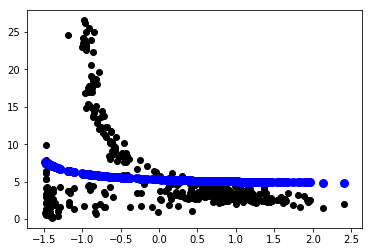

In [149]:
reg = linear_model.SGDRegressor(max_iter=1000)
reg.fit(data_precursor[['1/I_fluctration']], data_precursor['G_gp'])
pred = reg.predict(data_precursor[['1/I_fluctration']])
plt.scatter(data_precursor['I_fluctuation'], data_precursor['G_gp'],  color='black')
plt.scatter(data_precursor['I_fluctuation'], pred, color='blue', linewidth=3)

It does not work.

In [132]:
data_precursor['1/pearson_q'] = (1 / (1.8* data_precursor['pearson_q']+2)) 
data_precursor_test['1/pearson_q'] = (1 / (1.8*data_precursor_test['pearson_q']+2)) 

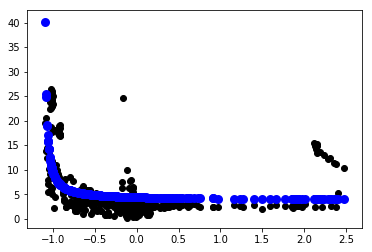

In [133]:
reg = linear_model.SGDRegressor(max_iter=1000)
reg.fit(data_precursor[['1/pearson_q']], data_precursor['G_gp'])
pred = reg.predict(data_precursor[['1/pearson_q']])
plt.scatter(data_precursor['pearson_q'], data_precursor['G_gp'],  color='black')
plt.scatter(data_precursor['pearson_q'], pred, color='blue', linewidth=3)

In [134]:
features = ["1/pearson_q"]

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['G_gp']], groups=data_precursor['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['G_gp'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.01, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'l2'}
Training score R2:  -0.750


In [135]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01,epsilon= 0.01, loss= 'huber', penalty= 'l2', max_iter=1000)
        reg.fit(tr[features], tr['G_gp'])
        test_r2 = reg.score(test[features], test['G_gp'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['G_gp'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.501514327709
test score mean squared error normalized:  0.315665557774

Testing on:  R2
R2 score:  -0.362658995149
test score mean squared error normalized:  0.141230813407

Testing on:  R3
R2 score:  -4.88885936476
test score mean squared error normalized:  1.39749483601

Testing on:  R4
R2 score:  -0.0667636364462
test score mean squared error normalized:  0.25138184026

Testing on:  R5
R2 score:  -0.602544878843
test score mean squared error normalized:  0.172998387239

Testing on:  R6
R2 score:  -0.292277799768
test score mean squared error normalized:  0.13971307393

Testing on:  R7
R2 score:  -2.33864290945
test score mean squared error normalized:  0.234125075392

Testing on:  Reaction_A
R2 score:  0.00135027337329
test score mean squared error normalized:  0.874824256161

Testing on:  Reaction_B
R2 score:  -0.18861789319
test score mean squared error normalized:  1.17173692155

Testing on:  Reaction_C
R2 score:  -0.450308641176
test score mean squa

In [150]:
features = ["1/pearson_q",'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['G_gp']], groups=data_precursor['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['G_gp'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.1, 'l1_ratio': 0.5, 'loss': 'huber', 'penalty': 'l2'}
Training score R2:  -0.628


In [152]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01,epsilon= 0.1, loss= 'huber', penalty= 'l2', max_iter=1000)
        reg.fit(tr[features], tr['G_gp'])
        test_r2 = reg.score(test[features], test['G_gp'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['G_gp'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.956900449818
test score mean squared error normalized:  0.355813650664

Testing on:  R2
R2 score:  -1.66919035823
test score mean squared error normalized:  0.203193112722

Testing on:  R3
R2 score:  -4.30767892594
test score mean squared error normalized:  1.30256780429

Testing on:  R4
R2 score:  -0.0191035071419
test score mean squared error normalized:  0.225763270857

Testing on:  R5
R2 score:  -0.240066978632
test score mean squared error normalized:  0.103504569067

Testing on:  R6
R2 score:  -0.0116047906885
test score mean squared error normalized:  0.111456232818

Testing on:  R7
R2 score:  -0.484733926524
test score mean squared error normalized:  0.131927214065

Testing on:  Reaction_A
R2 score:  0.307443929951
test score mean squared error normalized:  0.682579358056

Testing on:  Reaction_B
R2 score:  0.0933119021105
test score mean squared error normalized:  0.96220792189

Testing on:  Reaction_C
R2 score:  -0.108835370413
test score mean sq

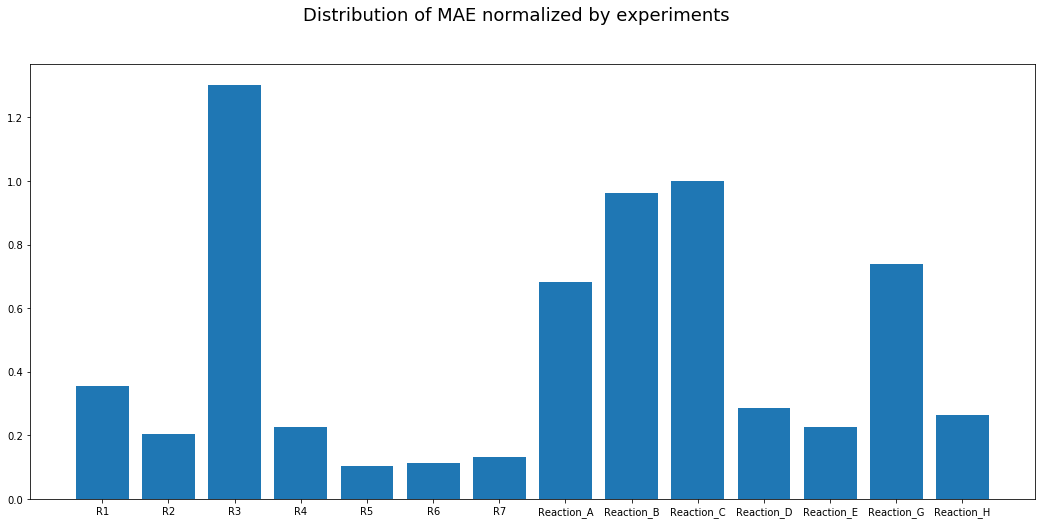

In [153]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

### rg_precursor

In [159]:
data_precursor = d[d['rg_gp'].isnull() == False]
data_precursor.shape

(518, 25)

In [160]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

scaler = preprocessing.StandardScaler()
scaler.fit(data_precursor[features])
data_precursor[features] = scaler.transform(data_precursor[features])
data_precursor.head()

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,guinier_porod,spherical_normal,diffraction_peaks,G_gp,rg_gp,D_gp,I0_sphere,r0_sphere,sigma_sphere,I0_floor
562,R4,-0.957153,0.068035,1.003365,-0.936117,-0.459400,0.557858,-0.462163,0.877374,0.066830,...,1,0,0,2.51472,2.31895,None,None,None,None,0.0337671
1476,Reaction_A,-0.107433,-0.143092,-0.862717,1.163160,0.485634,-0.278132,0.088542,-0.244916,0.063910,...,1,0,0,22.2753,4.86282,None,None,None,None,0
300,R2,-0.603234,0.279463,0.718758,-0.485172,-1.184825,-0.203692,-0.462163,0.157168,0.025048,...,1,0,0,4.36756,5.17536,None,None,None,None,0.0128569
1796,Reaction_E,1.220674,-0.207368,-0.923373,-0.337782,-0.241798,-0.374478,0.088542,-0.774249,0.051902,...,1,1,0,4.3769,4.66359,None,13.9542,10.3025,0.644579,0.00477838
301,R2,-0.690887,-0.050539,0.727830,-0.113734,-0.872740,-0.492607,-0.462163,0.242174,0.050725,...,1,0,0,3.77155,4.46501,None,None,None,None,0.00860808


In [161]:
#remove outliers for target variables only
labels = ['rg_gp']
st =  data_precursor[labels].std()
m = data_precursor[labels].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_precursor[labels].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

data_precursor = pd.concat([data_precursor.loc[:,c], filt_df], axis=1)
data_precursor.dropna(inplace=True)
data_precursor.shape

(509, 15)

In [162]:
data_precursor_test = data_precursor

# training data: remove outliers from features

cols = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

st =  data_precursor[cols].std()
m = data_precursor[cols].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_precursor[cols].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'rg_gp']
data_precursor = pd.concat([data_precursor.loc[:,c], filt_df], axis=1)
data_precursor.dropna(inplace=True)
data_precursor.shape

(424, 15)

In [163]:
experiments = data_precursor.experiment_id.unique()
experiments

array(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'Reaction_A',
       'Reaction_B', 'Reaction_C', 'Reaction_D', 'Reaction_E',
       'Reaction_G', 'Reaction_H'], dtype=object)

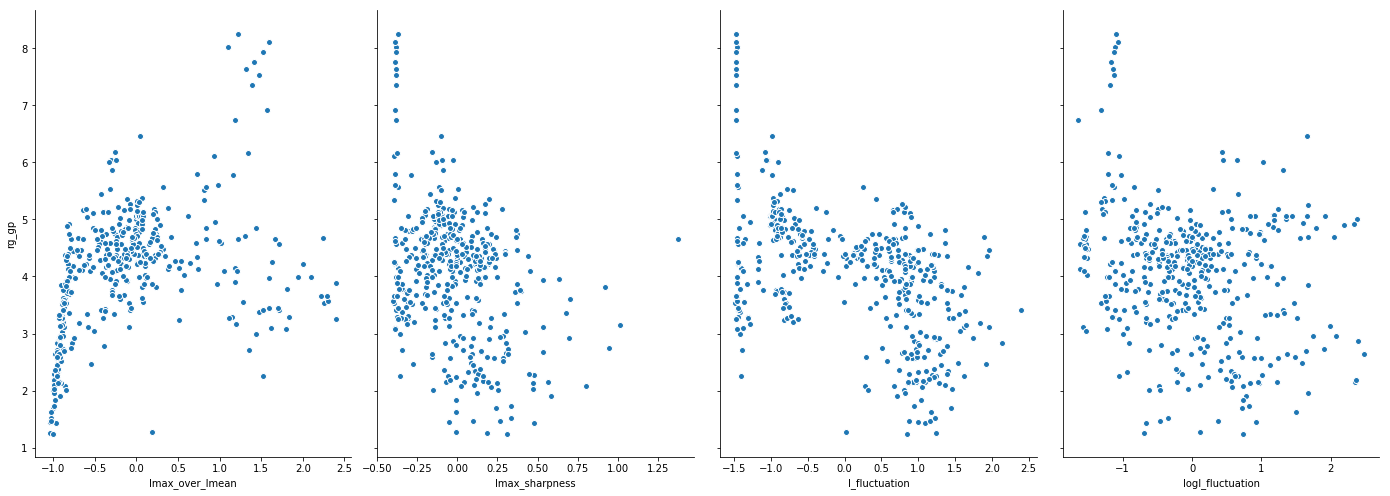

In [164]:
sns.pairplot(data_precursor, x_vars=['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation'], y_vars='rg_gp', size=7, aspect=0.7)

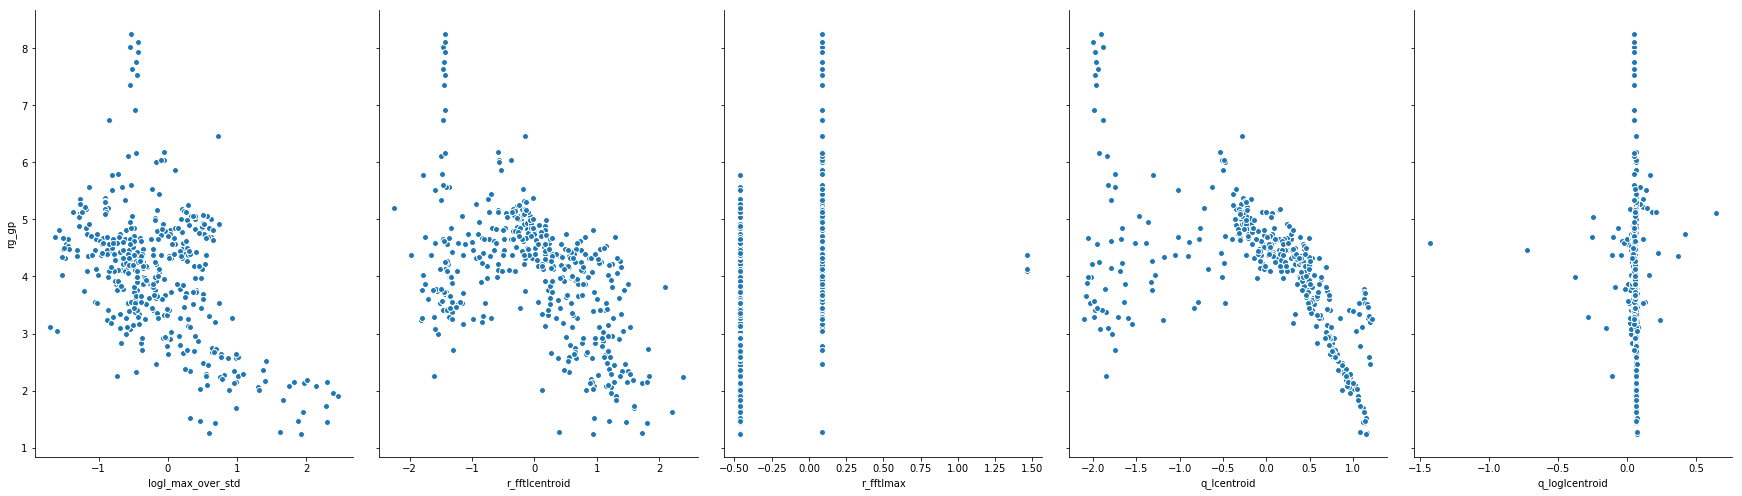

In [165]:
sns.pairplot(data_precursor, x_vars=['logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid'], y_vars='rg_gp', size=7, aspect=0.7)

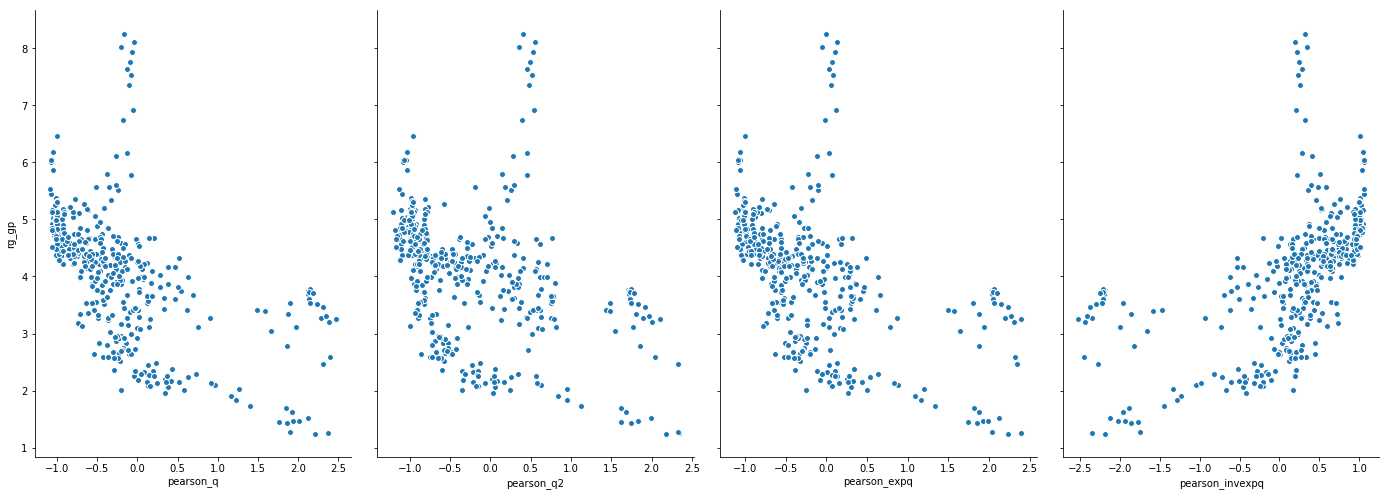

In [166]:
sns.pairplot(data_precursor, x_vars=['pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq'], y_vars='rg_gp', size=7, aspect=0.7)

In [168]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

for f in features:
    reg = linear_model.SGDRegressor(max_iter=1000)
    reg.fit(data_precursor[[f]], data_precursor['rg_gp'])
    pred = reg.predict(data_precursor[[f]])
    print("Mean squared error: %.5f"
      % mean_squared_error(data_precursor['rg_gp'], pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.5f' % r2_score(data_precursor['rg_gp'], pred))

Mean squared error: 1.03651
Variance score: 0.19758
Mean squared error: 1.12971
Variance score: 0.12543
Mean squared error: 0.94463
Variance score: 0.26871
Mean squared error: 1.21147
Variance score: 0.06213
Mean squared error: 0.97603
Variance score: 0.24440
Mean squared error: 0.94914
Variance score: 0.26522
Mean squared error: 1.01718
Variance score: 0.21255
Mean squared error: 0.89081
Variance score: 0.31037
Mean squared error: 1.29150
Variance score: 0.00017
Mean squared error: 0.91684
Variance score: 0.29022
Mean squared error: 1.10828
Variance score: 0.14202
Mean squared error: 0.96687
Variance score: 0.25149
Mean squared error: 0.87471
Variance score: 0.32284


#### Using all features

In [170]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['rg_gp']], groups=data_precursor['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['rg_gp'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 1, 'l1_ratio': 0.5, 'loss': 'huber', 'penalty': 'elasticnet'}
Training score R2:  -0.608


In [173]:
std_g_precursor = data_precursor['rg_gp'].std()

In [174]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01,epsilon= 1,l1_ratio= 0.5, loss= 'huber', penalty= 'elasticnet', max_iter=1000)
        reg.fit(tr[features], tr['rg_gp'])
        test_r2 = reg.score(test[features], test['rg_gp'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['rg_gp'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -7.95696466477
test score mean squared error normalized:  1.22648300288

Testing on:  R2
R2 score:  -1.89591832221
test score mean squared error normalized:  0.569836102405

Testing on:  R3
R2 score:  -2.91878347349
test score mean squared error normalized:  0.741644557101

Testing on:  R4
R2 score:  -0.112471235536
test score mean squared error normalized:  0.351457445258

Testing on:  R5
R2 score:  -0.0269287861969
test score mean squared error normalized:  0.649961660814

Testing on:  R6
R2 score:  -1.0556358936
test score mean squared error normalized:  0.455512855399

Testing on:  R7
R2 score:  0.415172244497
test score mean squared error normalized:  0.267162416644

Testing on:  Reaction_A
R2 score:  0.0100762818519
test score mean squared error normalized:  0.379725504942

Testing on:  Reaction_B
R2 score:  0.631410684185
test score mean squared error normalized:  0.231715568921

Testing on:  Reaction_C
R2 score:  -3.87428835037
test score mean squared

In [178]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_max_over_std', 'r_fftIcentroid', 
       'q_Icentroid',  'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['rg_gp']], groups=data_precursor['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['rg_gp'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'epsilon': 1, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'l2'}
Training score R2:  -0.636


In [179]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01,epsilon= 1,l1_ratio= 0.5, loss= 'huber', penalty= 'elasticnet', max_iter=1000)
        reg.fit(tr[features], tr['rg_gp'])
        test_r2 = reg.score(test[features], test['rg_gp'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['rg_gp'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -11.2489229245
test score mean squared error normalized:  1.43678905213

Testing on:  R2
R2 score:  -3.66822386099
test score mean squared error normalized:  0.540109104976

Testing on:  R3
R2 score:  -2.65822943805
test score mean squared error normalized:  0.763755949778

Testing on:  R4
R2 score:  -1.10145994037
test score mean squared error normalized:  0.495939446129

Testing on:  R5
R2 score:  -0.107368622146
test score mean squared error normalized:  0.706081049159

Testing on:  R6
R2 score:  -2.0518510814
test score mean squared error normalized:  0.561694465105

Testing on:  R7
R2 score:  0.451315520993
test score mean squared error normalized:  0.258990690433

Testing on:  Reaction_A
R2 score:  -0.339602200136
test score mean squared error normalized:  0.509786603207

Testing on:  Reaction_B
R2 score:  0.386703184633
test score mean squared error normalized:  0.311177416989

Testing on:  Reaction_C
R2 score:  0.649561025131
test score mean squared e

In [180]:
data_precursor['logI_max_over_std_squred'] = ( (data_precursor['logI_max_over_std'] - 2) ** 2) 
data_precursor_test['logI_max_over_std_squred'] = ( (data_precursor_test['logI_max_over_std'] - 2) ** 2)

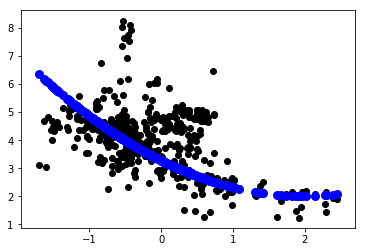

In [181]:
reg = linear_model.SGDRegressor(max_iter=10000, loss = 'huber', epsilon = 0.005)
reg.fit(data_precursor[['logI_max_over_std_squred']], data_precursor['rg_gp'])
pred = reg.predict(data_precursor[['logI_max_over_std_squred']])
plt.scatter(data_precursor['logI_max_over_std'], data_precursor['rg_gp'],  color='black')
plt.scatter(data_precursor['logI_max_over_std'], pred, color='blue', linewidth=3)

In [184]:
features = ['logI_max_over_std_squred']

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['rg_gp']], groups=data_precursor['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['rg_gp'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'epsilon': 0.001, 'l1_ratio': 0.15, 'loss': 'squared_loss', 'penalty': 'none'}
Training score R2:  -2.364


In [185]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.0001,epsilon= 1,l1_ratio= 0.15, loss= 'huber', penalty= 'l1', max_iter=1000)
        reg.fit(tr[features], tr['rg_gp'])
        test_r2 = reg.score(test[features], test['rg_gp'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['rg_gp'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -8.43110440594
test score mean squared error normalized:  1.27737361049

Testing on:  R2
R2 score:  0.130674484499
test score mean squared error normalized:  0.275287374499

Testing on:  R3
R2 score:  -0.372320620213
test score mean squared error normalized:  0.410318411245

Testing on:  R4
R2 score:  -8.86946737175
test score mean squared error normalized:  1.26990428341

Testing on:  R5
R2 score:  -3.23052892044
test score mean squared error normalized:  1.54837228622

Testing on:  R6
R2 score:  -6.33721941765
test score mean squared error normalized:  0.890608647326

Testing on:  R7
R2 score:  0.215035945858
test score mean squared error normalized:  0.340782480135

Testing on:  Reaction_A
R2 score:  -4.10156130324
test score mean squared error normalized:  1.17113087204

Testing on:  Reaction_B
R2 score:  -2.63220406471
test score mean squared error normalized:  0.753508936012

Testing on:  Reaction_C
R2 score:  -1.32728520401
test score mean squared erro

In [182]:
features = ['logI_max_over_std_squred','Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_max_over_std', 'r_fftIcentroid', 
       'q_Icentroid',  'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['rg_gp']], groups=data_precursor['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['rg_gp'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'epsilon': 1, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'l1'}
Training score R2:  -0.634


In [183]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.0001,epsilon= 1,l1_ratio= 0.15, loss= 'huber', penalty= 'l1', max_iter=1000)
        reg.fit(tr[features], tr['rg_gp'])
        test_r2 = reg.score(test[features], test['rg_gp'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['rg_gp'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -10.2374610841
test score mean squared error normalized:  1.37503356595

Testing on:  R2
R2 score:  -12.3783247223
test score mean squared error normalized:  0.763025992886

Testing on:  R3
R2 score:  -1.95820489792
test score mean squared error normalized:  0.690198442084

Testing on:  R4
R2 score:  -0.960078023896
test score mean squared error normalized:  0.493864639311

Testing on:  R5
R2 score:  0.130438392072
test score mean squared error normalized:  0.618258533146

Testing on:  R6
R2 score:  -1.57774232801
test score mean squared error normalized:  0.506974592146

Testing on:  R7
R2 score:  0.439926522125
test score mean squared error normalized:  0.261744633875

Testing on:  Reaction_A
R2 score:  -0.232369661336
test score mean squared error normalized:  0.469941978005

Testing on:  Reaction_B
R2 score:  0.382517152663
test score mean squared error normalized:  0.320025290685

Testing on:  Reaction_C
R2 score:  0.577640234724
test score mean squared 

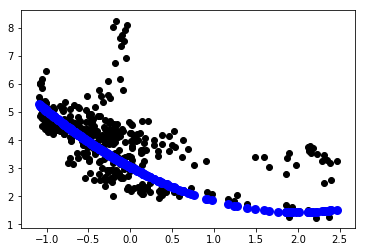

In [187]:
data_precursor['pearson_q_squred'] = ( (data_precursor['pearson_q'] - 2) ** 2) 
data_precursor_test['pearson_q_squred'] = ( (data_precursor_test['pearson_q'] - 2) ** 2)

reg = linear_model.SGDRegressor(max_iter=10000, loss = 'huber', epsilon = 0.005)
reg.fit(data_precursor[['pearson_q_squred']], data_precursor['rg_gp'])
pred = reg.predict(data_precursor[['pearson_q_squred']])
plt.scatter(data_precursor['pearson_q'], data_precursor['rg_gp'],  color='black')
plt.scatter(data_precursor['pearson_q'], pred, color='blue', linewidth=3)

In [188]:
features = ['pearson_q_squred','logI_max_over_std_squred','Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_max_over_std', 'r_fftIcentroid', 
       'q_Icentroid',  'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['rg_gp']], groups=data_precursor['experiment_id'])

reg = linear_model.SGDRegressor( max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['rg_gp'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'epsilon': 1, 'l1_ratio': 0.5, 'loss': 'huber', 'penalty': 'l2'}
Training score R2:  -0.254


In [189]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.0001,epsilon= 1,l1_ratio= 0.5, loss= 'huber', penalty= 'l2', max_iter=1000)
        reg.fit(tr[features], tr['rg_gp'])
        test_r2 = reg.score(test[features], test['rg_gp'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['rg_gp'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -9.01563439531
test score mean squared error normalized:  1.28890308583

Testing on:  R2
R2 score:  -9.91550471742
test score mean squared error normalized:  0.551376610153

Testing on:  R3
R2 score:  -0.0850594183565
test score mean squared error normalized:  0.346444533418

Testing on:  R4
R2 score:  -0.220447002107
test score mean squared error normalized:  0.308286019557

Testing on:  R5
R2 score:  0.555262282133
test score mean squared error normalized:  0.448913544027

Testing on:  R6
R2 score:  -0.476659175226
test score mean squared error normalized:  0.359622144688

Testing on:  R7
R2 score:  0.572992087296
test score mean squared error normalized:  0.224786493128

Testing on:  Reaction_A
R2 score:  0.0143691454509
test score mean squared error normalized:  0.409682373539

Testing on:  Reaction_B
R2 score:  0.492101771081
test score mean squared error normalized:  0.290198698203

Testing on:  Reaction_C
R2 score:  0.493508555465
test score mean squar

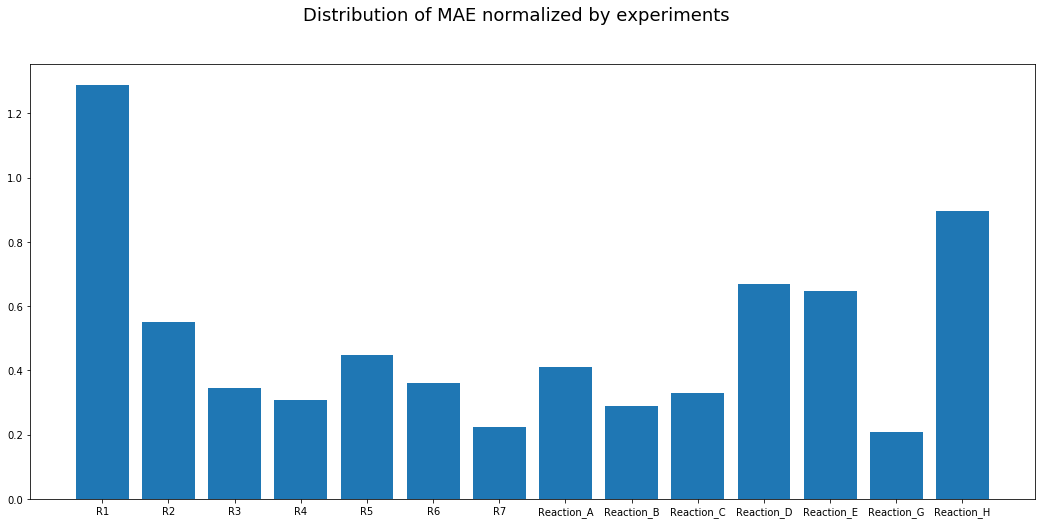

In [190]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()



|            | Average testing mean absolute error normalized | features
| ------------- | ------------- 
| ro_sphere  | 0.12 | all 13 features
| sigma_sphere |  0.79 | 'Imax_over_Imean', 'Imax_sharpness', 'q_Icentroid', 'pearson_q', 'pearson_q2','pearson_expq','pearson_invexpq'
|G_gp | 0.47  | **"1/pearson_q"**,'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation','logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax','q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2','pearson_expq', 'pearson_invexpq'
| rg_gp | 0.49 | **'pearson_q_squred','logI_max_over_std_squred'**,'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation','logI_max_over_std', 'r_fftIcentroid', 'q_Icentroid',  'pearson_q', 'pearson_q2','pearson_expq','pearson_invexpq'